<a href="https://colab.research.google.com/github/deadex-ng/Rossman-sales/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive"

 1_hT2N_iAmjBi-7gryAzqjyQ.png		    JobsFumbaniBanda.gdoc
 Classroom				    minutes.gdoc
'Colab Notebooks'			    rossdata
'Copy of Functional Resume Template.gdoc'   Twitter-Data-Analysis-main
 DesignThinkingFumbaniBanda.gslides	   'Untitled document.gdoc'
 dvc-data				    week1
 FinalReportFumbaniBanda.gdoc		    week2
 FinalReportFumbaniBanda.pptx		    week3
 fprophet				    WorldJobs.gdoc
'FumbaniBanda Resume.pdf'


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
import pandas as pd 
data = pd.read_csv("/content/drive/My Drive/rossdata/train.csv",index_col='Date',nrows=20000)
#Only 20,000 rows have been selected from the dataset because of limited computing power

I had to limit the number of rows because checking for stationarity just kept hanging if the number of rows was high

In [ ]:
data.head(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1


In [ ]:
data.shape

(20000, 8)

We just need 'Date' and 'Sales' for forecasting, so we drop all other columns.

In [ ]:
storeSales = data.copy()
storeSales.drop(['Store','DayOfWeek','Customers','Open','Promo','StateHoliday','SchoolHoliday'],axis=1,inplace=True)

Scale the Sales data and put the scaled values in a new column.

In [ ]:
scaler = MinMaxScaler()
scaler.fit(storeSales.Sales.values.reshape([-1, 1]))
storeSalesScaled = scaler.transform(storeSales.Sales.values.reshape(-1, 1))
storeSales['storeSalesScaled'] = storeSalesScaled
storeSales.head(10)

,Sales,storeSalesScaled
Date,,
2015-07-31,5263,0.161705
2015-07-31,6064,0.186315
2015-07-31,8314,0.255446
2015-07-31,13995,0.429994
2015-07-31,4822,0.148155
2015-07-31,5651,0.173626
2015-07-31,15344,0.471441
2015-07-31,8492,0.260915
2015-07-31,8565,0.263158


In [ ]:
storeSales.describe()

,Sales,storeSalesScaled
count,20000.000000,20000.000000
mean,6359.995900,0.195410
std,3563.680614,0.109493
min,0.000000,0.000000
25%,4542.500000,0.139567
50%,6271.000000,0.192675
75%,8237.250000,0.253088
max,32547.000000,1.000000


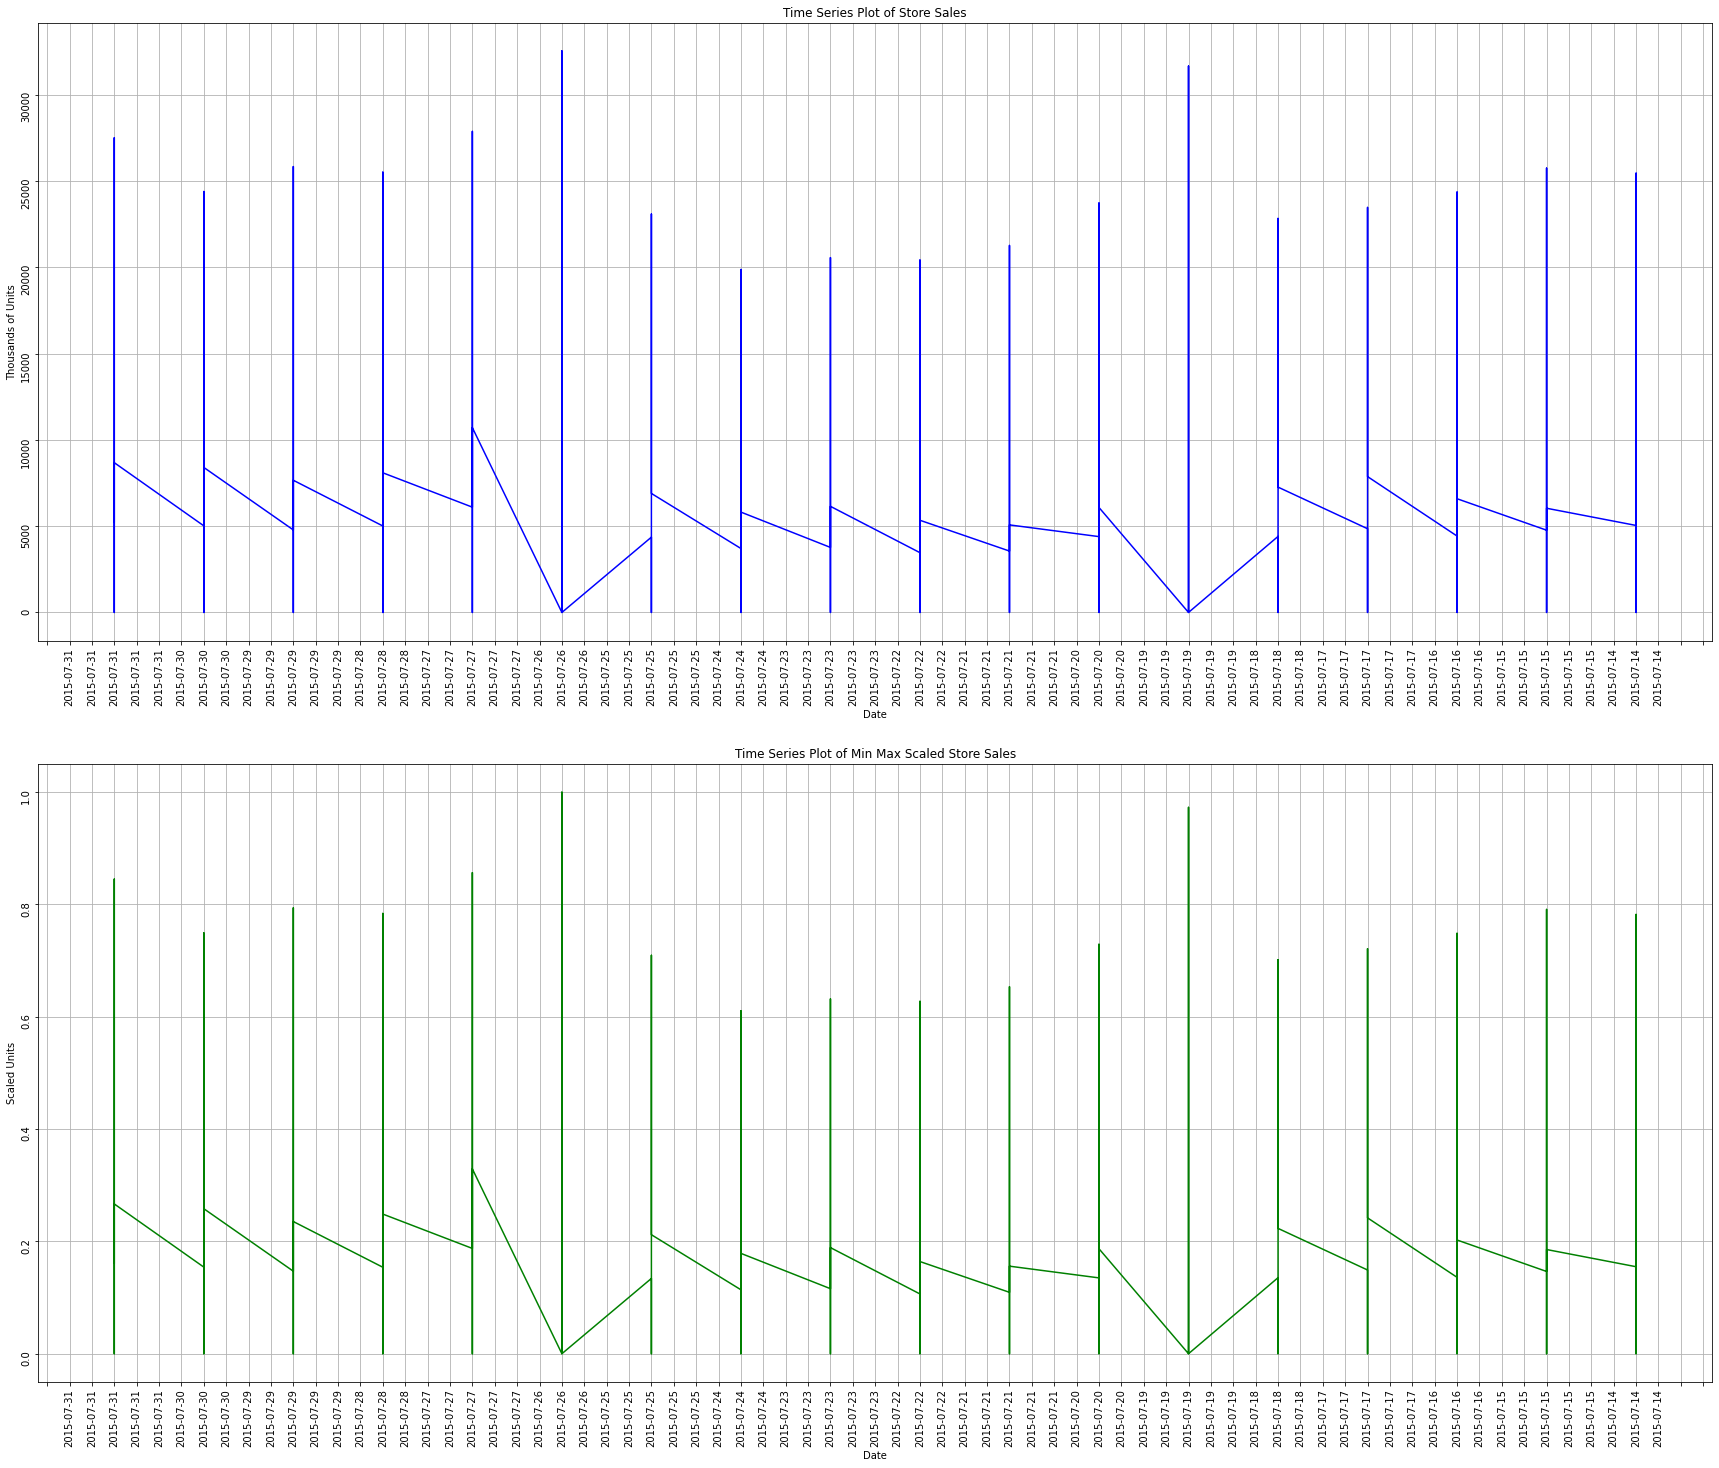

In [ ]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(25)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 80
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(storeSales.index, storeSales.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Store Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(storeSales.index, storeSales.storeSalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled Store Sales')
ax2.grid(True)
plt.show()

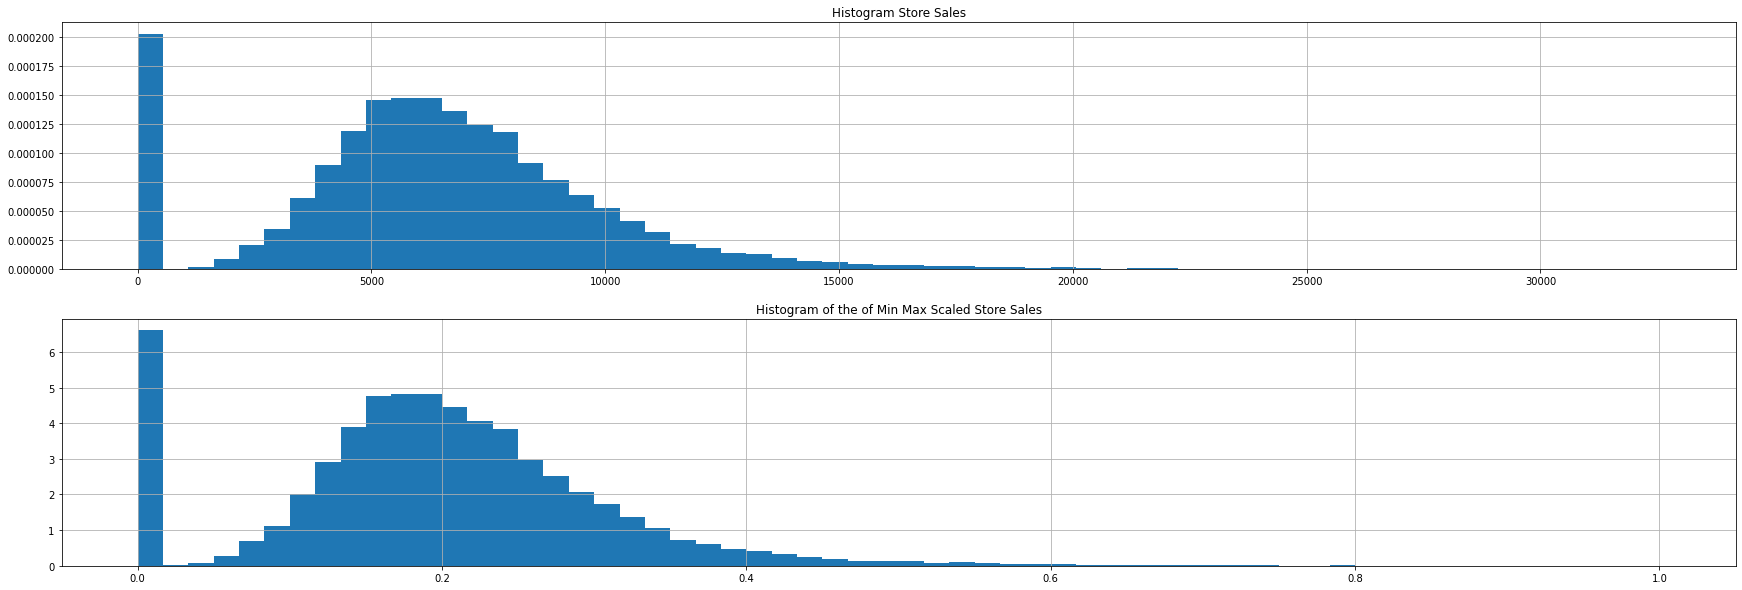

In [ ]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(storeSales.Sales, density=True, bins=60)
ax1.title.set_text('Histogram Store Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(storeSales.storeSalesScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled Store Sales')
ax2.grid(True)
plt.show()

In [ ]:
adfResult = adfuller(storeSales.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'n_lags: {adfResult[1]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -3.9298303535057535
n_lags: 0.0018259566824130476
p-value: 0.0018259566824130476


The p-value obtained is less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the data is stationary.

In [ ]:
adfResult = adfuller(storeSales.storeSalesScaled.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'n_lags: {adfResult[1]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -3.9298303535058188
n_lags: 0.001825956682412613
p-value: 0.001825956682412613


The p-value obtained is less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the data is stationary.

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [ ]:
storeSalesDif = difference(storeSales.storeSalesScaled.values)

In [ ]:
acfSalesScaled = acf(storeSales.storeSalesScaled.values, fft=True, nlags=25)
acfSalesScaledNp = np.array(acfSalesScaled)

In [ ]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of Store Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

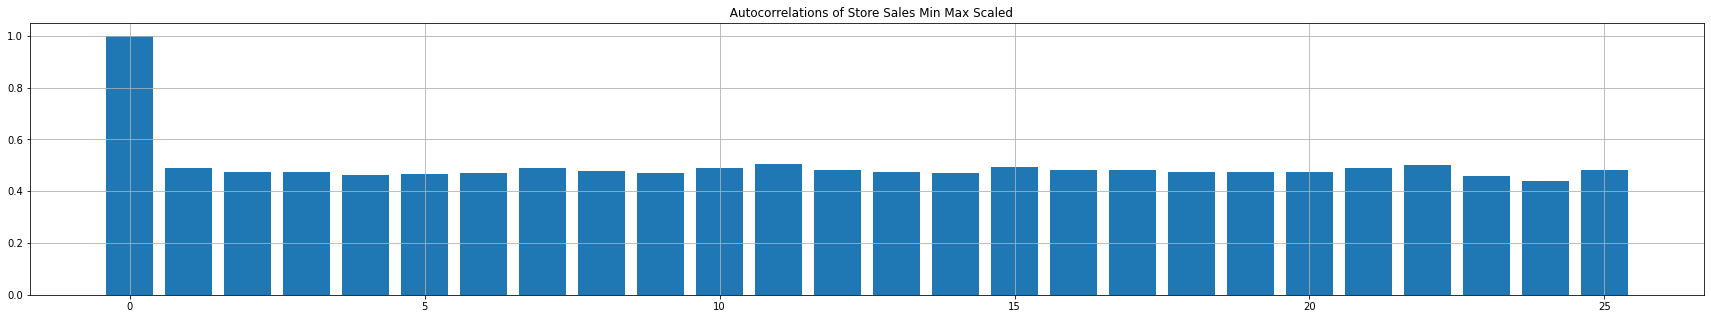

In [ ]:
corrPlots(acfSalesScaledNp, '')

In [ ]:
pacfSalesScaled = pacf(storeSales.storeSalesScaled.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

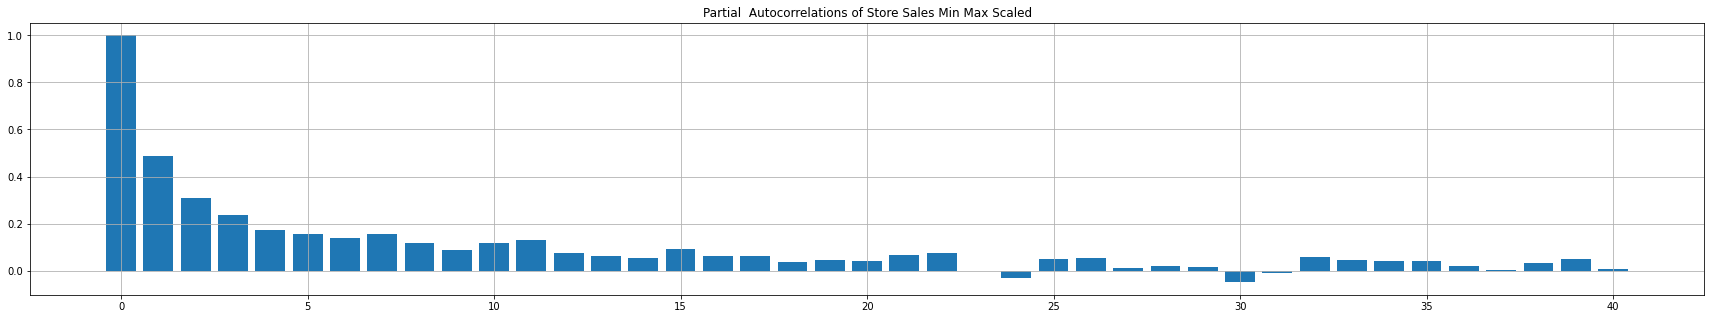

In [ ]:
corrPlots(pacfSalesScaledNp, "Partial")

In [ ]:
SIZE = len(storeSales.storeSalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

In [ ]:
DateTrain = storeSales.index.values[0:BATCH_SIZE]
DateValid = storeSales.index.values[BATCH_SIZE:]
XTrain = storeSales.storeSalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = storeSales.storeSalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (19904, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (19904,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [ ]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([19904, 1])

In [ ]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset shapes: (1,), types: tf.float32>

In [ ]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [ ]:
# Example of Window
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [ ]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [ ]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [ ]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

In [ ]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 8)           320       
_________________________________________________________________
lstm_5 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 8s 8s/step - loss: 0.0403 - val_loss: 0.0594
Epoch 2/200
1/1 [==============================] - 4s 4s/step - loss: 0.0383 - val_loss: 0.0567
Epoch 3/200
1/1 [==============================] - 4s 4s/step - loss: 0.0363 - val_loss: 0.0540
Epoch 4/200
1/1 [==============================] - 4s 4s/step - loss: 0.0344 - val_loss: 0.0514
Epoch 5/200
1/1 [==============================] - 4s 4s/step - loss: 0.0327 - val_loss: 0.0489
Epoch 6/200
1/1 [==============================] - 4s 4s/step - loss: 0.0309 - val_loss: 0.0466
Epoch 7/200
1/1 [==============================] - 4s 4s/step - loss: 0.0293 - val_loss: 0.0443
Epoch 8/200
1/1 [==============================] - 4s 4s/step - loss: 0.0277 - val_loss: 0.0421
Epoch 9/200
1/1 [==============================] - 4s 4s/step - loss: 0.0262 - val_loss: 0.0399
Epoch 10/200
1/1 [==============================] - 3s 3s/step - loss: 0.0248 - val_loss: 0.0379
Epoch 11/200
1/1 [=====================

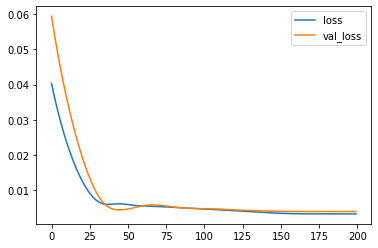

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [ ]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
Forecast = model_forecast(model, storeSales.storeSalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

Model Evaluation.

MAE tells us how big of error we can expect from the model.
RMSE tells measures the error of the model in predicting quantitative data.



In [ ]:
MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

In [ ]:
print(textstr)

MAE = 8320.520  RMSE = 8755.526
